In [9]:
### Importing modules
from io import BytesIO
import numpy as np
import pandas as pd
from ipywidgets import Layout, interact, fixed, interactive
from IPython.display import Image
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import sys
from scipy import ndimage
from scipy.ndimage import gaussian_filter1d as gf1d
from skimage import measure
%matplotlib notebook
import matplotlib
from matplotlib import pylab
import skimage
from skimage import filters, feature, io
from matplotlib import cm
from matplotlib.pyplot import figure
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, \
    scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h

In [2]:
#This is just a function to help us go from an array to another type of
#  data structure that can be more easily displayed

def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', matplotlib.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    if arr.dtype == 'uint8':
        vmax=255
        vmin=0
    elif arr.dtype == 'uint16':
        vmin = arr.min()
        vmax = arr.max()
    else:
        vmax=arr.max()
        vmin=arr.min()
    with BytesIO() as buffer:
        matplotlib.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=vmin, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

# Here, we'll find the droplet's size and position and then use PIV to see how it is expanding/contracting and how fluid/solid it is

### First, we'll read in the data

In [3]:
# Specify the directory where the data is
data_directory = "Y:\\Ryle\\Data\\2021-04-02\\RR0104012021\\Set 1\\Heating_Trial_01\\"

In [4]:
#Specify the file name
data_file = "Export_20x_HG_Heating_crop1_Frames1to2200.tif"
#data_file = "11_40XS_60X_DIC_PFS_StackReg_Shrink.tif"

In [5]:
#Read in the image file
im=skimage.io.imread(data_directory+data_file)

In [6]:
print("Shape of the image data file: (%i,%i,%i)" % im.shape)
print("So each image is %i-by-%i pixels large and we have %i frames in our movie." % (im.shape[1], im.shape[2], im.shape[0]))

Shape of the image data file: (2200,148,148)
So each image is 148-by-148 pixels large and we have 2200 frames in our movie.


### Optimizing parameters

Here, we are finding the parameters necessary to locate the droplet. That is, for any pixel in the image, we want to know if that pixel is *within* or *outside* the droplet. 

<IPython.core.display.Javascript object>


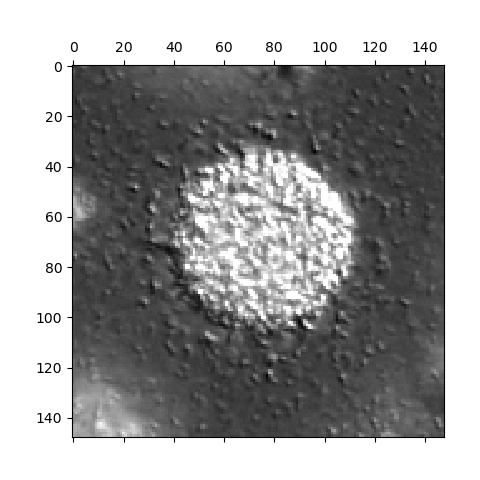

In [7]:
# Just to check things out, take a look at one of the images

%matplotlib notebook

##############################################################
# CHOOSE A FRAME TO LOOK AT.
# You should open the movie in ImageJ. Find a frame where
# the droplet is shrinking and somewhat gelled.
##############################################################
image_number = 700 #this is the frame number we'll look at


plt.matshow(im[image_number], cmap=plt.cm.gray)

Next, we try filtering the image.

Before you go further, you should check out [this tutorial on image processing](http://scipy-lectures.org/advanced/image_processing/). In particular, pay close attention to the sections on image filtering and feature extraction. 

In [13]:
def edit_image_using_filter(image_stack, im_number, sigma, sobel_filter, scharr_filter):
    new_image = ndimage.gaussian_filter(image_stack[im_number], sigma)
    if sobel_filter:
        new_image = sobel(new_image)
    elif scharr_filter:
        new_image = scharr(new_image)
    if sobel_filter and scharr_filter:
        new_image = sobel(scharr(new_image))
    return arr2img(new_image)

v=interact(edit_image_using_filter, image_stack=fixed(im), im_number=(0,im.shape[0]-1,10), sigma=(0,20,1),
          sobel_filter=False, scharr_filter=False)
display(v)

interactive(children=(IntSlider(value=1090, description='im_number', max=2199, step=10), IntSlider(value=10, d…

<function __main__.edit_image_using_filter(image_stack, im_number, sigma, sobel_filter, scharr_filter)>

In [19]:
##########################################################################################
# MAKE SURE YOU ARE OKAY WITH THE SETTINGS PRINTED BELOW (RUN THIS CELL TO SEE...)       #
##########################################################################################


filter_settings = {'gaussian_sigma': v.widget.kwargs['sigma'], 'sobel': v.widget.kwargs['sobel_filter'], 
                  'scharr': v.widget.kwargs['scharr_filter']}
print(filter_settings)

{'gaussian_sigma': 5, 'sobel': False, 'scharr': False}


What we want to do is to locate the boundaries of our droplet. <br>
Again, **make sure** that the settings for image filtering above are okay. 

In the next cell, we find the threshold value to turn this image into a black and white (aka, binary) image.

In [20]:
def threshold_determination(image_stack, im_number, filter_dictionary, blackwhite_threshold_fraction):
    new_image = ndimage.gaussian_filter(image_stack[im_number], filter_dictionary['gaussian_sigma'])
    if filter_dictionary['sobel']:
        new_image = sobel(new_image)
    elif filter_dictionary['scharr']:
        new_image = scharr(new_image)
    if filter_dictionary['sobel'] and filter_dictionary['scharr']:
        new_image = sobel(scharr(new_image))
        
    bw_threshold = blackwhite_threshold_fraction*new_image.max()  
    bw_image = new_image>bw_threshold
        
    return arr2img(bw_image)

v2=interact(threshold_determination, image_stack=fixed(im), im_number=(0,im.shape[0]-1,10), 
           filter_dictionary=fixed(filter_settings), blackwhite_threshold_fraction=(0.5,1,0.02))
display(v2)

interactive(children=(IntSlider(value=1090, description='im_number', max=2199, step=10), FloatSlider(value=0.7…

<function __main__.threshold_determination(image_stack, im_number, filter_dictionary, blackwhite_threshold_fraction)>

In [21]:
filter_settings['bw_threshold']=v2.widget.kwargs['blackwhite_threshold_fraction']

print(filter_settings)

{'gaussian_sigma': 5, 'sobel': False, 'scharr': False, 'bw_threshold': 0.76}


In [22]:
def binary_operations(image_stack, im_number, filter_dictionary, iterations_binary_closing, binary_fill_holes, 
                      iterations_erosion):
    new_image = ndimage.gaussian_filter(image_stack[im_number], filter_dictionary['gaussian_sigma'])
    if filter_dictionary['sobel']:
        new_image = sobel(new_image)
    elif filter_dictionary['scharr']:
        new_image = scharr(new_image)
    if filter_dictionary['sobel'] and filter_dictionary['scharr']:
        new_image = sobel(scharr(new_image))
        
    bw_threshold = filter_dictionary['bw_threshold']*new_image.max()  
    bw_image = new_image>bw_threshold
    
    if iterations_binary_closing>0:
        bw_image = ndimage.morphology.binary_closing(bw_image,iterations=iterations_binary_closing)
    if binary_fill_holes:
        bw_image = ndimage.morphology.binary_fill_holes(bw_image)
    if iterations_erosion>0:
        bw_image = ndimage.morphology.binary_erosion(bw_image,iterations=iterations_erosion)
        
    return arr2img(bw_image)

v3=interact(binary_operations, image_stack=fixed(im), im_number=(0,im.shape[0]-1,10), 
           filter_dictionary=fixed(filter_settings), iterations_binary_closing=(0,20,1),
           binary_fill_holes=False, iterations_erosion=(0,20,1))
display(v3)

interactive(children=(IntSlider(value=1090, description='im_number', max=2199, step=10), IntSlider(value=10, d…

<function __main__.binary_operations(image_stack, im_number, filter_dictionary, iterations_binary_closing, binary_fill_holes, iterations_erosion)>

In [27]:
filter_settings['iterations_binary_closing']=v3.widget.kwargs['iterations_binary_closing']
filter_settings['binary_fill_holes']=v3.widget.kwargs['binary_fill_holes']
filter_settings['iterations_erosion']=v3.widget.kwargs['iterations_erosion']
print(filter_settings)

{'gaussian_sigma': 5, 'sobel': False, 'scharr': False, 'bw_threshold': 0.76, 'iterations_binary_closing': 18, 'binary_fill_holes': True, 'iterations_erosion': 3}


Based on the parameters you determine work best above, let's make a function that does all that. With this function, we can quickly process a series of images.

In [28]:
################################################################################################
# Parameters that you optimized above are use here. They can be used as the default values for
# the arguments to this 'generate_mask' function. 
###############################################################################################

def generate_mask(image_stack, im_number, filter_dictionary, radius_fraction=0.9):
    '''

    '''


    new_image = ndimage.gaussian_filter(image_stack[im_number], filter_dictionary['gaussian_sigma'])
    if filter_dictionary['sobel']:
        new_image = sobel(new_image)
    elif filter_dictionary['scharr']:
        new_image = scharr(new_image)
    if filter_dictionary['sobel'] and filter_dictionary['scharr']:
        new_image = sobel(scharr(new_image))
        
    bw_threshold = filter_dictionary['bw_threshold']*new_image.max()  
    bw_image = new_image>bw_threshold
    
    if filter_dictionary['iterations_binary_closing']>0:
        bw_image = ndimage.morphology.binary_closing(bw_image,iterations=filter_dictionary['iterations_binary_closing'])
    if filter_dictionary['binary_fill_holes']:
        bw_image = ndimage.morphology.binary_fill_holes(bw_image)
    if filter_dictionary['iterations_erosion']>0:
        bw_image = ndimage.morphology.binary_erosion(bw_image,iterations=filter_dictionary['iterations_erosion'])
        
    
    #Set the edge to zero (if bits of other droplets are shown at the edges, we want them gone)
    edge = 1
    value_to_replace = 0
    bw_image[0:edge,:] = value_to_replace
    bw_image[:,-edge:] = value_to_replace
    bw_image[-edge:,:] = value_to_replace
    bw_image[:,0:edge] = value_to_replace
    
    #find the center of mass of the binary image
    com = ndimage.center_of_mass(bw_image)
    #find the radius of the droplet (assuming the area is pi * radius^2)
    radius = np.sqrt(bw_image.sum()/np.pi)
    
    #locate the center of the image
    xc = new_image.shape[0]/2
    yc = new_image.shape[1]/2

    ## this if-else checks if image is even or odd
    if (new_image.shape[1] % 2) and (new_image.shape[0] % 2):
        xx,yy = np.meshgrid(np.arange(-1*yc,yc+1,1)-com[1]+yc,np.arange(-1*xc,xc+1,1)-com[0]+xc)
    elif (new_image.shape[1] % 2) and not (new_image.shape[0] % 2):
        xx,yy = np.meshgrid(np.arange(-1*yc,yc+1,1)-com[1]+yc,np.arange(-1*xc,xc,1)-com[0]+xc)
    elif not (new_image.shape[1] % 2) and (new_image.shape[0] % 2):
        xx,yy = np.meshgrid(np.arange(-1*yc,yc,1)-com[1]+yc,np.arange(-1*xc,xc+1,1)-com[0]+xc)
    else:
        xx,yy = np.meshgrid(np.arange(-1*yc,yc,1)-com[1]+yc,np.arange(-1*xc,xc,1)-com[0]+xc)

    r = np.sqrt(xx**2 + yy**2)
    rmask = r<(radius_fraction*radius)
    
    return bw_image, rmask, radius, com


In [29]:
im[0].shape[0] % 2

0

<IPython.core.display.Javascript object>


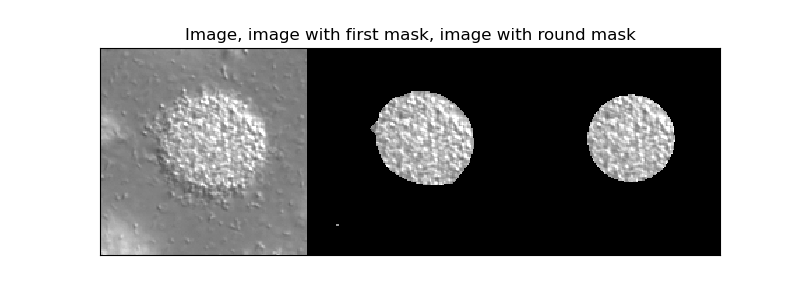

We found the radius of this droplet to be 34.7
We found the droplet's center of mass to be at 64,83


In [40]:
#Try out this function for different frames (just change the 'image_number')
image_number = 1550

mask, rmask, rad, com = generate_mask(im, image_number, filter_settings)

#Let's see the results
plt.figure(figsize=(8,3))
plt.matshow(np.c_[im[image_number], im[image_number]*mask, im[image_number]*rmask], cmap=cm.gray, fignum=False)
plt.xticks([]); plt.yticks([])
plt.title("Image, image with first mask, image with round mask")

print("We found the radius of this droplet to be %.1f" % rad)
print("We found the droplet's center of mass to be at %i,%i" % com)

In [42]:
################################################################################################
# Now we can do this for many frames of the movies. We'll just pick the ones where the 
# droplet is shrinking and expanding. So just before it starts to gel to right after it
# turns to a fluid. 
###############################################################################################

#enter in the start frame and the end frame here
start = 571
end = 1600

#first we initialize some arrays, for storing data
mask = im[start:end,:,:].copy()
round_mask = im[start:end,:,:].copy()
radii = np.zeros((mask.shape[0]))
brightness = np.zeros((mask.shape[0]))
centers_of_mass = np.zeros((mask.shape[0],2))

#then, we'll look over the set of images (from frames `start' to `end')
for i in range(mask.shape[0]):
    justmask, rmask, rad, com = generate_mask(im, start+i, filter_settings)
    mask[i] = justmask
    round_mask[i] = rmask
    radii[i] = rad
    centers_of_mass[i] = com
    w = np.nonzero(justmask)
    brightness[i] = np.mean(justmask[w]*im[start+i][w])

In [43]:
print("Shape of 'mask': ", mask.shape)

Shape of 'mask':  (1029, 148, 148)


<IPython.core.display.Javascript object>


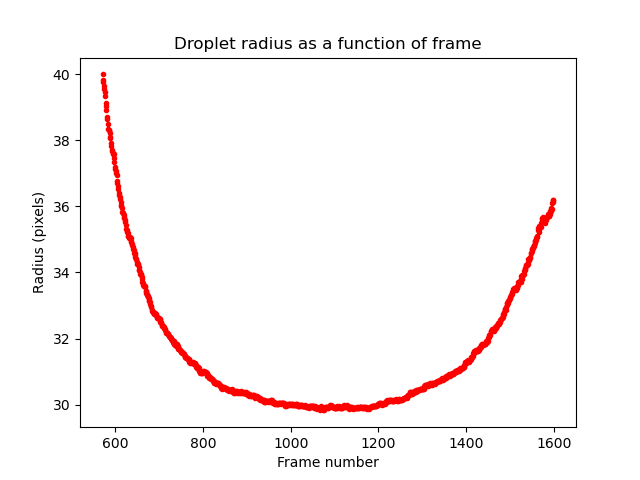

<IPython.core.display.Javascript object>


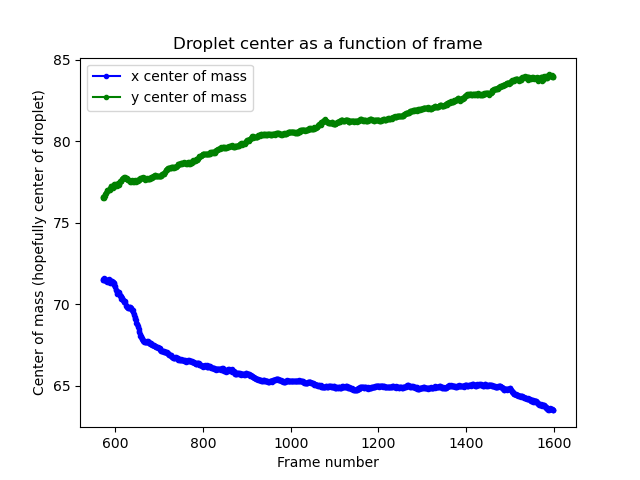

<IPython.core.display.Javascript object>


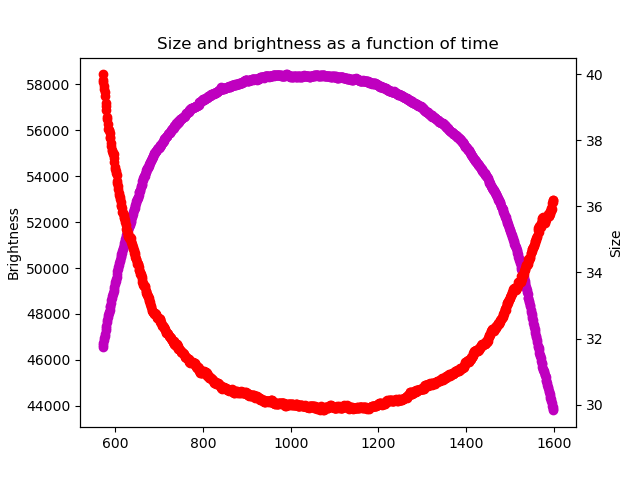

<IPython.core.display.Javascript object>


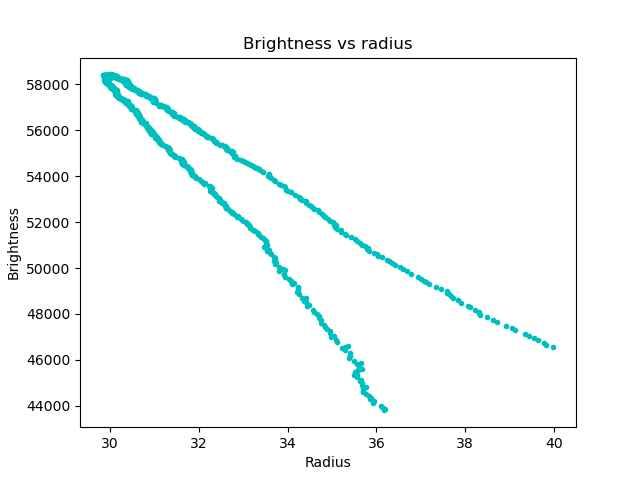

Text(0.5, 1.0, 'Brightness vs radius')

In [44]:
frames = np.arange(start,end)

plt.figure()
plt.plot(frames,radii,'r.')
plt.ylabel("Radius (pixels)")
plt.xlabel("Frame number")
plt.title('Droplet radius as a function of frame')

plt.figure()
plt.plot(frames,centers_of_mass[:,0],'-b.',label="x center of mass")
plt.plot(frames,centers_of_mass[:,1],'-g.',label="y center of mass")
plt.ylabel("Center of mass (hopefully center of droplet)")
plt.xlabel("Frame number")
plt.title("Droplet center as a function of frame")
plt.legend()


fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(frames,radii,'-ro')
ax2.set_ylabel("Size")
ax1.plot(frames,brightness,'-mo')
ax1.set_ylabel("Brightness")
plt.title("Size and brightness as a function of time")

plt.figure()
plt.plot(radii,brightness,'c.')
plt.ylabel("Brightness")
plt.xlabel("Radius")
plt.title('Brightness vs radius')

In [40]:
################################################################################################
# Run this to inspect how well the code did in finding the droplet. 
# After you run this, open up the generated tiff file (which should be in 
# the same directory this ipynb file is in)
###############################################################################################

## THIS WILL SAVE THE PROCESSED MOVIE IN YOUR CODE DIRECTORY!
tiff_file.imsave(data_file[:-4]+"_test.tif", im_matrix_new)

## Now to doing PIV work

You will likely need to install the Python package [numdifftools](https://numdifftools.readthedocs.io/en/latest/tutorials/install.html) for this to work. Check out that link for installation instructions. <br>

Most likely, all you will need to do is open up an Anaconda Prompt. Then just type: <br>
> `pip install numdifftools`
<br>

<br>You'll also need to install the Python package [openpiv](https://github.com/OpenPIV/openpiv-python). To install, you'll again open up an Anaconda Prompt and type: <br>
> `conda install -c conda-forge openpiv`

In [19]:
import numdifftools as nd
from openpiv import tools, scaling, pyprocess, validation, filters

In [20]:
from openpiv import piv

<IPython.core.display.Javascript object>


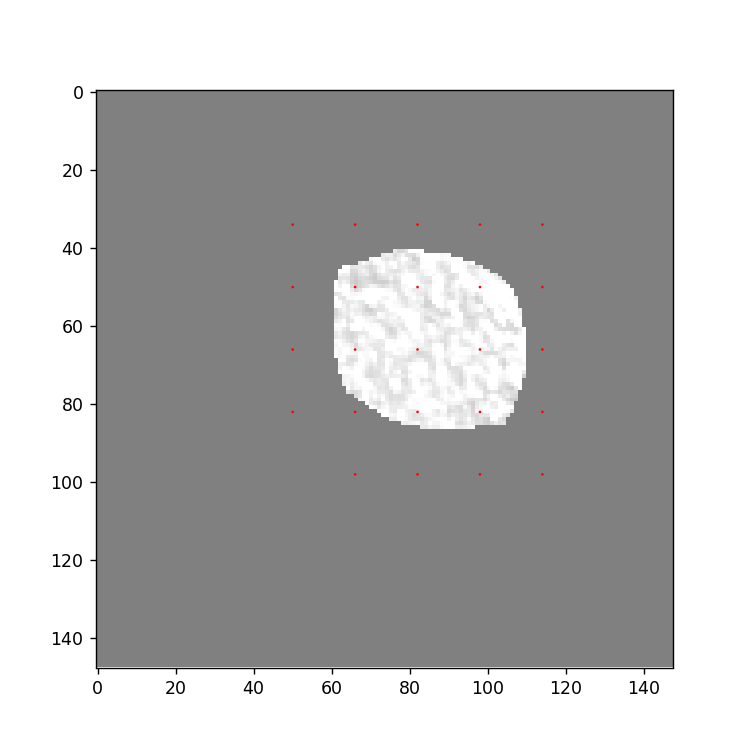

(8, 8)
(8, 8)
(8, 8)
(8, 8)


In [21]:
frame1 = 1000
frame2 = 1020
x,y,u,v = piv.simple_piv(mask[frame1]*mask[frame2]*im[frame1],mask[frame1]*mask[frame2]*im[frame2])
print(x.shape)
print(y.shape)
print(u.shape)
print(v.shape)

Here, we begin the PIV analysis.

In [43]:
################################################################################################
# We have set some default parameters. Ones that have worked (for this movie, #10 in 2/28/2020)
# are:
#     winsize = 28
#     searchsize = 36
#     overlap = 22
# We don't need to worry about dt.
###############################################################################################

def generate_vector_field(frame_index1, frame_index2, im, mask, centers_of_mass,
                          winsize=28, searchsize=36, overlap=22, dt=0.02, 
                          clearaxes=True, tosave=True, driftcorrect=True):
    
    #print(mask.shape)
    
    frame1 = im[frame_index1].copy().astype(np.float) * mask[frame_index1] * mask[frame_index2]
    frame2 = im[frame_index2].copy().astype(np.float) * mask[frame_index1] * mask[frame_index2]
    
    
    cx1 = np.int(centers_of_mass[frame_index1,0]); cy1 = np.int(centers_of_mass[frame_index1,1])
    cx2 = np.int(centers_of_mass[frame_index2,0]); cy2 = np.int(centers_of_mass[frame_index2,1])
       
    newsize=int((im[0].shape[0]/2)-40) #really, half the new size of the image
    newsize = 50
    #print(newsize)
    
    frame1_new2 = frame1[cx1-newsize:cx1+newsize,cy1-newsize:cy1+newsize]
    frame2_new2 = frame2[cx2-newsize:cx2+newsize,cy2-newsize:cy2+newsize]
    
    mask2_1 = mask[frame_index1, cx1-newsize:cx1+newsize, cy1-newsize:cy1+newsize]
    mask2_2 = mask[frame_index2, cx2-newsize:cx2+newsize, cy2-newsize:cy2+newsize]
    mask2 = mask2_1*mask2_2

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame1_new2.astype(np.int32), frame2_new2.astype(np.int32),
                                                         window_size=winsize, overlap=overlap, dt=dt, 
                                                         search_area_size=searchsize, sig2noise_method='peak2peak' )
    w = np.where(np.isfinite(sig2noise) == False)
    sig2noise[w] = 1000
    
    x, y = pyprocess.get_coordinates( image_size=frame1_new2.shape, search_area_size=searchsize, overlap=overlap )
    u1, v1, masksig2noise = validation.sig2noise_val( u0.copy(), v0.copy(), sig2noise, threshold = 1.15 ) #threshold was 1.15
    new_mask2 = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            xcoord = np.int(x[i,j])
            ycoord = np.int(y[i,j])
            if xcoord<mask2.shape[0]:
                if ycoord<mask2.shape[1]:
                    if mask2[xcoord,ycoord]>0:
                        new_mask2[i,j]=1                       
    u1 = u1*new_mask2
    v1 = v1*new_mask2
    
    u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2) #max_iter=10, kernel_size=2
    #u2 = u1.copy(); v2 = v1.copy()
    
    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 1 )
    
    MAXIMUM_DISPLACEMENT = 60
    w = np.where(abs(u3)>MAXIMUM_DISPLACEMENT)
    u3[w]=0
    w = np.where(abs(v3)>MAXIMUM_DISPLACEMENT)
    v3[w]=0
    
    
    piv_vector_length = np.sqrt(u3**2 + v3**2)
    w = np.where(piv_vector_length>0)
    piv_length_mean = piv_vector_length[w].mean()
    piv_length_std = piv_vector_length[w].std()
    w = np.where(piv_vector_length > (piv_length_mean+2*piv_length_std))
    v3[w]=0
    u3[w]=0
    
    '''
    plot_every = 1
    plt.matshow(np.flipud(frame1_new2),cmap=cm.gray,fignum=False)
    plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
               1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
               np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
               cmap=cm.jet, scale=3000)
    if tosave:
        plt.savefig("Z:\\JackBrady_F19\\Code\\RJM Fields\\v2\\vector_field_%i_to_%i.png" % (frame_index1,frame_index2))
    if clearaxes:
        plt.cla()
    '''
    
    mask2_1 = mask[frame_index1, cx1-newsize:cx1+newsize, cy1-newsize:cy1+newsize]
    mask2_2 = mask[frame_index2, cx2-newsize:cx2+newsize, cy2-newsize:cy2+newsize]
    
    mask2 = mask2_1*mask2_2
    
    #Getting div...
    new_mask2 = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            xcoord = np.int(x[i,j])
            ycoord = np.int(y[i,j])
            if xcoord<mask2.shape[0]:
                if ycoord<mask2.shape[1]:
                    if mask2[xcoord,ycoord]>0:
                        new_mask2[i,j]=1
                        
                        
    u3 = u3*new_mask2
    v3 = v3*new_mask2
    
    '''This here is for removing drift'''
    if driftcorrect:
        w_u3_0 = np.where(u3==0)
        w_v3_0 = np.where(v3==0)

        u3_mean = u3[abs(u3)>0].mean()
        v3_mean = v3[abs(v3)>0].mean()

        #u3_mean = u3.mean()
        #v3_mean = v3.mean()

        u3 = u3-u3_mean
        v3 = v3-v3_mean
        u3 = u3*new_mask2
        v3 = v3*new_mask2
    
    '''Done with drift removal'''
    
    plot_every = 1
    plt.matshow(np.flipud(im[frame_index1,cx1-newsize:cx1+newsize,cy1-newsize:cy1+newsize]),cmap=cm.gray,fignum=False)
    plt.quiver(x[::plot_every,::plot_every],y[::plot_every,::plot_every],
               1*u3[::plot_every,::plot_every], -1*v3[::plot_every,::plot_every],
               np.sqrt(u3[::plot_every,::plot_every]**2 + v3[::plot_every,::plot_every]**2),
               cmap=cm.jet, scale=500)
    if tosave:
        plt.savefig("Y:\\Ryle\\Data\\2021-04-02\\RR0104012021\\Set 1\\Heating_Trial_01\\Drop2_PIV\\vector_field_%i_to_%i.png" % (frame_index1,frame_index2))
    if clearaxes:
        plt.cla()
    
    dudx = u3[1:,:]-u3[:-1,:]
    dudy = u3[:,1:]-u3[:,:-1]
    dvdx = v3[1:,:]-v3[:-1,:]
    dvdy = v3[:,1:]-v3[:,:-1]
    div = dudy[1:,:]-dvdx[:,1:]
    new_div = div*new_mask2[1:,1:]
    w = np.where(abs(new_div)>0)
    if len(new_div[w])==0:
        div_median=0
    else:
        div_median = np.median(new_div[w])
    
    
    curl = dudx[:,1:]+dvdy[1:,:]
    new_curl = curl*new_mask2[1:,1:]
    w = np.where(abs(new_curl)>0)
    if len(new_curl[w])==0:
        curl_median=0
        curl_rms = 0
        curl_std = 0
    else:
        curl_median = np.median(new_div[w])
        curl_median = np.median(new_curl[w])
        curl_rms = np.mean(new_curl[w]**2)
        curl_std = np.std(new_curl[w])
        
    return x,y,u3,v3,piv_vector_length, div_median, curl_median, curl_rms, curl_std

<IPython.core.display.Javascript object>


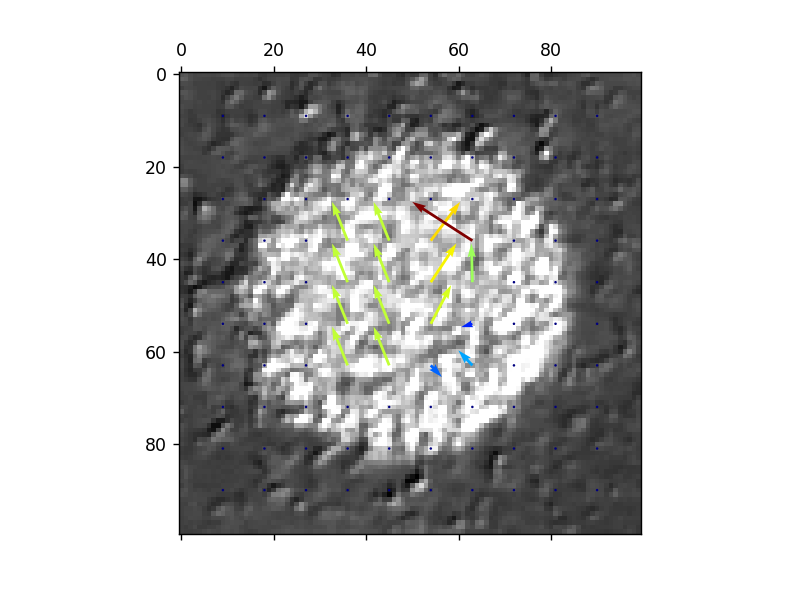

Shape of u3 is:  (10, 10)


In [44]:
################################################################################################
# Now we run that code. 
# We try it just on one frame (index is the index of the selected set of frames to look at).
#    So the actual frame is 'start+index' (remember setting 'start' and 'end' above?)
# 'step' is the interval between frames. Here it is set to 2. So we look at frame x and frame
#    x+2 and see how things have shifted.

# winsize=28, searchsize=36, overlap=22
###############################################################################################
#mask, rmask, rmask2, rad, com
plt.figure()
index=140
step = 10 
x,y,u3,v3,pvl, div, clm, clrms, clstd = generate_vector_field(index,index+step,im[start:end,:,:], mask, centers_of_mass,
                                                              clearaxes=False, tosave=True,
                                                              winsize=6, searchsize=14, overlap=5);
print("Shape of u3 is: ", u3.shape)

In [23]:
# If you forgot what we set 'start' and 'end' to, see here...

print("Start and end frames: %i,%i" % (start,end))

Start and end frames: 571,1600


In [35]:
################################################################################################
# Now we run that code OVER ALL FRAMES FROM start TO end. 
#
# Here, we have 'step=1'
# and 'winsize=14, searchsize=20, overlap=10'
#
#
# You can try adjusting these.
###############################################################################################


step=5
indices = np.arange(0,end-start-step,1)
divs = np.zeros_like(indices)*1.0
clms = np.zeros_like(divs)
clrms = np.zeros_like(clms)
clstds = np.zeros_like(clms)

plt.figure(figsize=(8,8))
j=0
for i in indices:
    x,y,u3,v3,pvl, divs[j], clms[j], clrms[j], clstds[j] = generate_vector_field(i,i+step,im[start:end,:,:],mask, 
                                                                                 centers_of_mass,
                                                                                 tosave=True,
                                                                                 winsize=8, searchsize=22, overlap=6)
    j=j+1
    
    
#default: winsize=28, searchsize=36, overlap=22
#what has also worked (for step=2): winsize=18, searchsize=24, overlap=12

<IPython.core.display.Javascript object>

<ipython-input-32-8ae1de41a8fd>:43: RuntimeWarning: Mean of empty slice.
  piv_length_mean = piv_vector_length[w].mean()
<ipython-input-32-8ae1de41a8fd>:85: RuntimeWarning: Mean of empty slice.
  u3_mean = u3[abs(u3)>0].mean()
<ipython-input-32-8ae1de41a8fd>:86: RuntimeWarning: Mean of empty slice.
  v3_mean = v3[abs(v3)>0].mean()


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


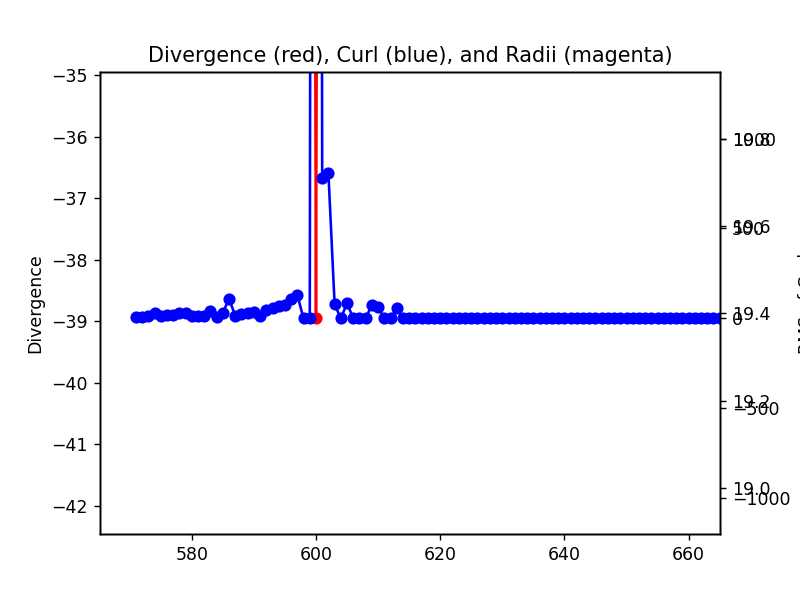

Text(0.5, 1.0, 'Divergence (red), Curl (blue), and Radii (magenta)')

In [25]:
#############################################################
# Here we plot the results!
#############################################################

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(frames[indices],divs,'-ro')
ax1.set_ylabel("Divergence")
ax2.plot(frames[indices],clrms,'-bo')
ax2.set_ylabel("RMS of Curl")
ax3.plot(frames[indices],radii[indices],'-mo')

plt.title("Divergence (red), Curl (blue), and Radii (magenta)")

<IPython.core.display.Javascript object>


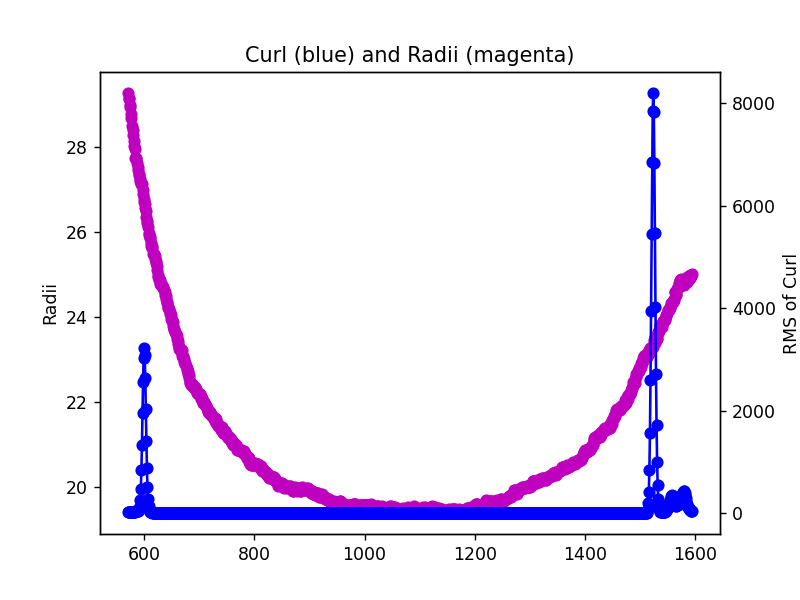

Text(0.5, 1.0, 'Curl (blue) and Radii (magenta)')

In [26]:
#############################################################
# Let's smooth the data. And not show the divergence.
#############################################################

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax3 = ax1.twinx()
ax2.plot(frames[indices],gf1d(clrms,3),'-bo')
ax2.set_ylabel("RMS of Curl")
#ax3.plot(frames[indices],gf1d(divs,15),'-ro')
#ax3.set_ylabel("Divergence")
ax1.plot(frames[indices],radii[indices],'-mo')
ax1.set_ylabel("Radii")

plt.title("Curl (blue) and Radii (magenta)")

<IPython.core.display.Javascript object>


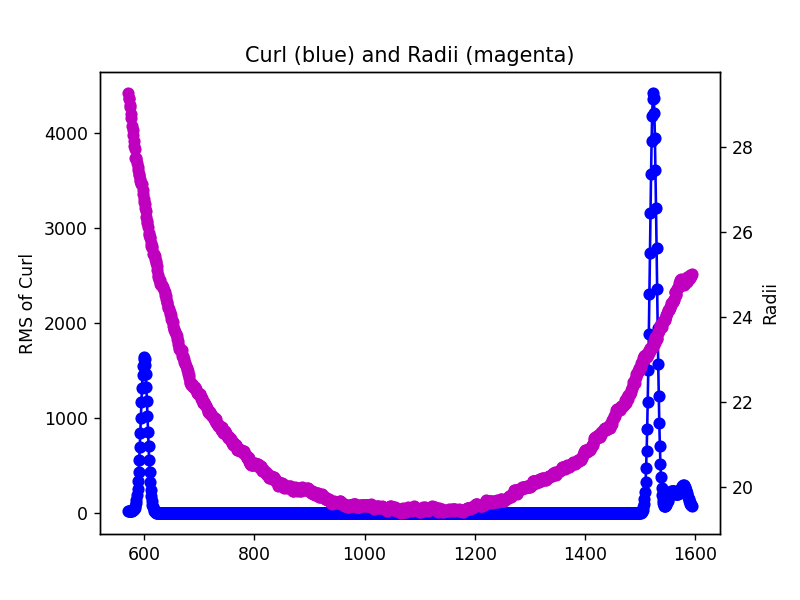

Text(0.5, 1.0, 'Curl (blue) and Radii (magenta)')

In [28]:
#############################################################
# Try to locate the "corners" of the curl
#############################################################

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(frames[indices],gf1d(clrms,6),'-bo')
ax1.set_ylabel("RMS of Curl")
ax2.plot(frames[indices],radii[indices],'-mo')
ax2.set_ylabel("Radii")

#ax1.axvline(368,c='k',lw=4,alpha=0.8)
#ax1.axvline(604,c='k',lw=4,alpha=0.8)

plt.title("Curl (blue) and Radii (magenta)")

In [ ]:
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("RMS of Curl")
ax1.plot(gf1d(clrms,3),radii[indices],'-mo')
ax1.set_ylabel("Radii")